In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
defaults.cmap = 'binary'
#to check it
defaults.cmap

'binary'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_test_drive = "/content/drive/MyDrive/train_test/AUGMENTED_High_Low_angle.zip"

In [4]:
import shutil
shutil.unpack_archive(train_test_drive, "/content/")

In [2]:
base_size = 64
to_film_ar = lambda height: (height, int(height * 16/9))
img_size = to_film_ar(base_size)

In [3]:
def xtra_tfms(base_size = base_size): 
    box_dim = int(base_size/4)
    cutout_ = partial(cutout, p = .8, n_holes = (1,1), length = (box_dim, box_dim))
    jitter_ = partial(jitter, p = 0.5,  magnitude = (0.005, 0.01))
    skew_   = partial(skew,   p = 0.5, direction = (0, 7), magnitude = 0.2)
    squish_ = partial(squish, p = 0.5, row_pct = 0.25, col_pct = 0.25)
    tilt_   = partial(tilt,   p = 0.5, direction = (0, 3))
    perp_warp_ = partial(perspective_warp, p = 0.5, magnitude = (-0.2, 0.2))
    crop_pad_  = partial(crop_pad, p = 0.5, padding_mode = 'border', row_pct = 0.1, col_pct = 0.1)
    rgb_randomize_ = partial(rgb_randomize, thresh=0.05)
    
    
    xtra_tfms = [jitter_(), skew_(), squish_(), perp_warp_(),
                 tilt_(), cutout_(), crop_pad_()]
    
    return xtra_tfms

In [4]:
def get_tfms(): return get_transforms(do_flip = True,
                                      flip_vert = False,
                                      max_zoom = 1.,
                                      max_lighting = 0.4,
                                      max_warp = 0.3,
                                      p_affine = 0.85,
                                      p_lighting = 0.85,
                                      xtra_tfms = xtra_tfms())

In [5]:
bs = 64
base_size = 90

tfms = get_tfms()
img_size = to_film_ar(base_size)

img_size

(90, 160)

In [6]:
path = "/content/High_Low_angle"
np.random.seed(42)

src = ImageList.from_folder(path).random_split_by_pct(valid_pct=0.2, seed=4).label_from_folder()
tfms = get_tfms() 
size=img_size 
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(bs=bs, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current sys

In [7]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  size=img_size, ds_tfms=tfms, bs=bs, resize_method=ResizeMethod.SQUISH, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
data.classes

['High', 'Low', 'Med']

In [9]:
print(data.train_ds)
print()
print(data.valid_ds)

LabelList (1440 items)
x: ImageList
Image (3, 90, 160),Image (3, 90, 160),Image (3, 90, 160),Image (3, 90, 160),Image (3, 90, 160)
y: CategoryList
Low,Low,Low,Low,Low
Path: /content/High_Low_angle

LabelList (360 items)
x: ImageList
Image (3, 90, 160),Image (3, 90, 160),Image (3, 90, 160),Image (3, 90, 160),Image (3, 90, 160)
y: CategoryList
Med,High,Med,Med,Low
Path: /content/High_Low_angle


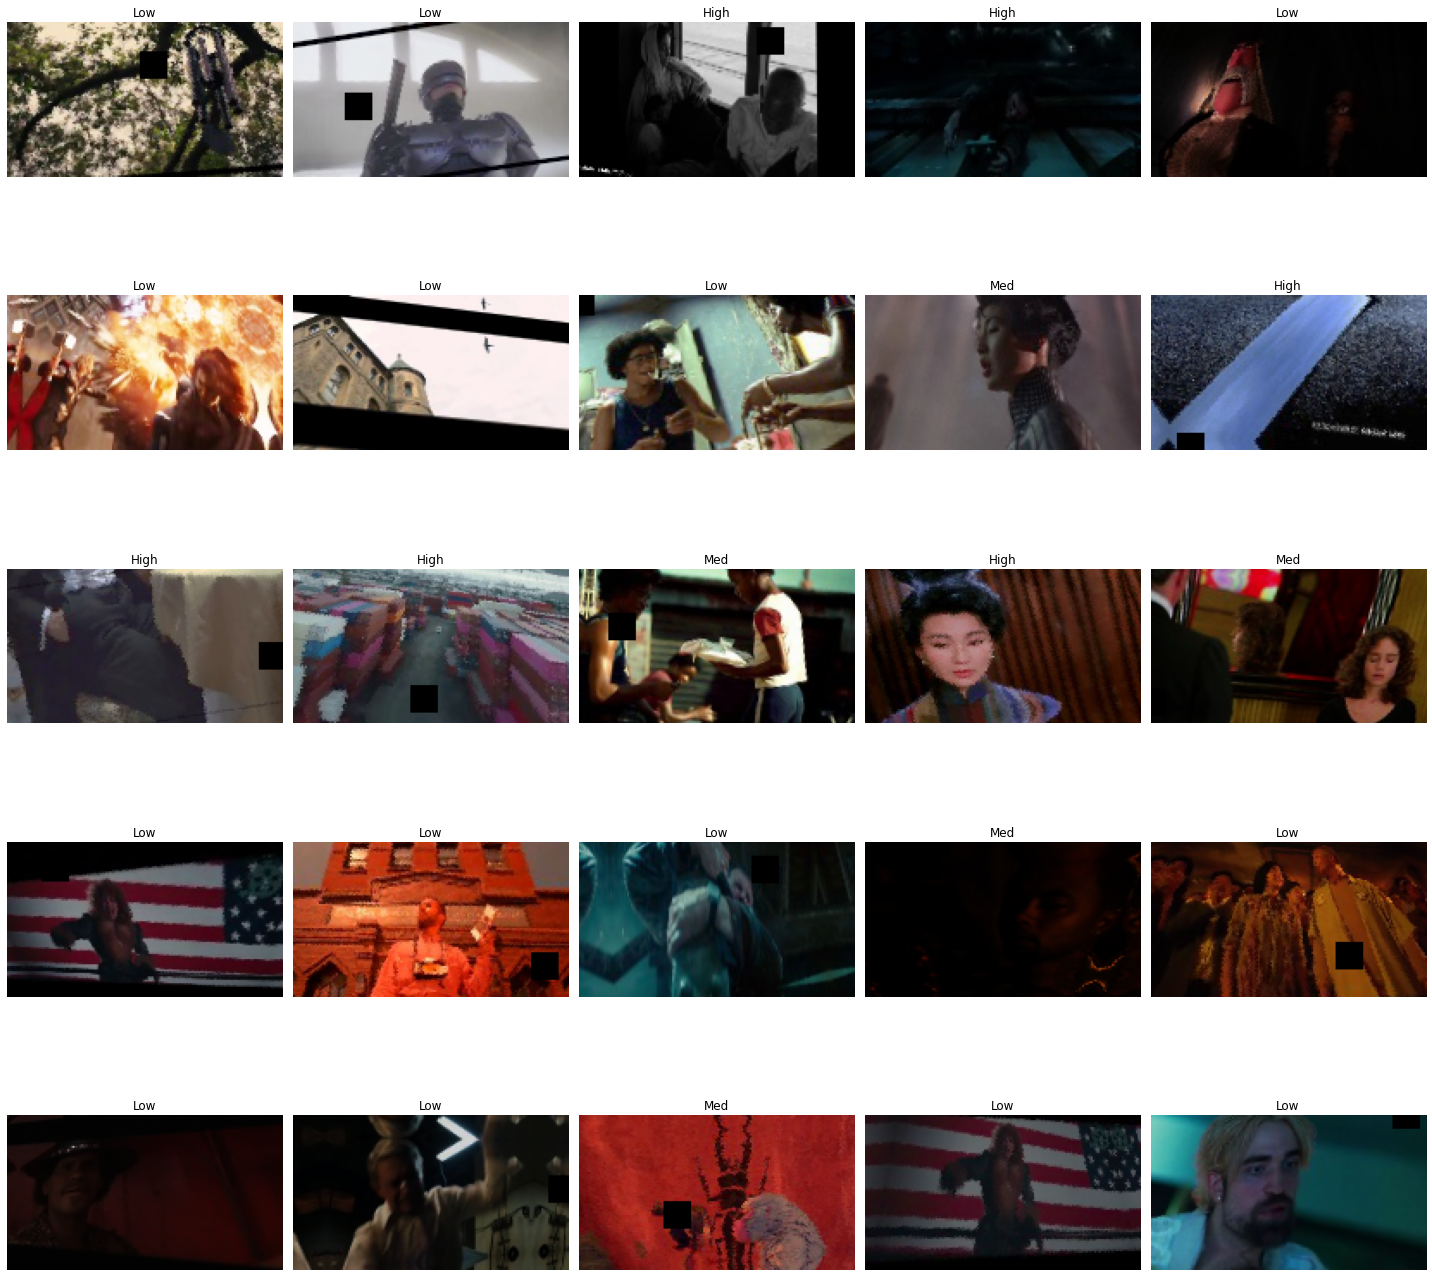

In [10]:
data.show_batch()

In [11]:
learn = cnn_learner(data, models.resnet50, metrics = [accuracy], pretrained=True)
learn = learn.to_fp16()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


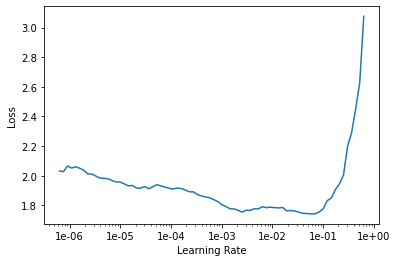

In [12]:
import warnings
warnings.filterwarnings('ignore')
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(8, slice(3e-3))


epoch,train_loss,valid_loss,accuracy,time
0,1.625785,1.150037,0.602778,00:12
1,1.624565,1.301004,0.594444,00:11
2,1.424934,0.862287,0.650000,00:11
3,1.228214,0.689149,0.716667,00:11
4,1.083239,0.662446,0.705556,00:11
5,0.973408,0.607460,0.733333,00:11
6,0.871564,0.582681,0.733333,00:11
7,0.811997,0.588428,0.733333,00:11


In [14]:
learn.save('HighLow-1-1')

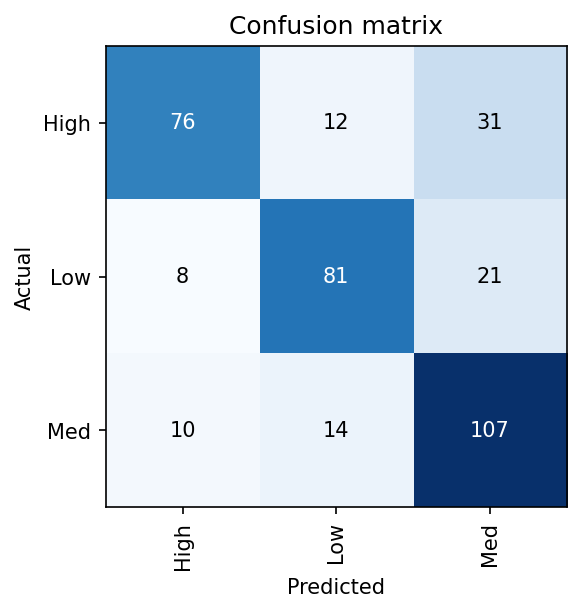

In [15]:
learn.load('HighLow-1-1');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 150)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


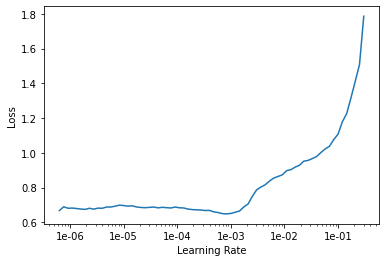

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(8, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.694579,0.612333,0.722222,00:14
1,0.722162,0.780369,0.763889,00:13
2,0.716741,1.011749,0.672222,00:14
3,0.637808,0.504587,0.813889,00:14
4,0.527443,0.429692,0.852778,00:13
5,0.429362,0.452172,0.855556,00:14
6,0.336995,0.390075,0.872222,00:13
7,0.265787,0.359107,0.897222,00:14


In [18]:
learn.save('HighLow-1-2')

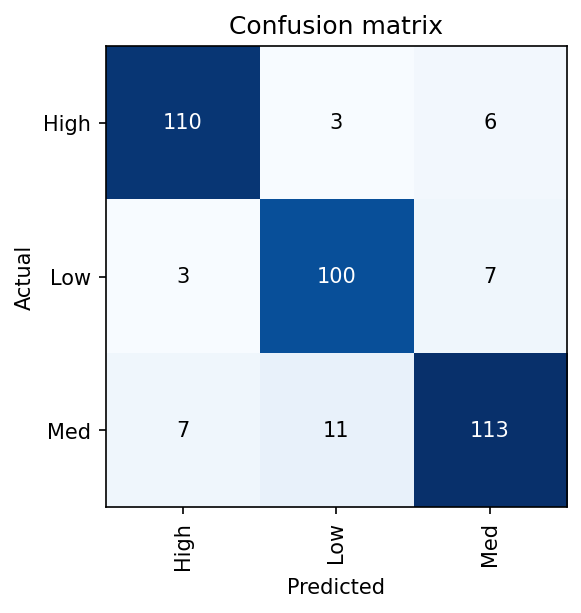

In [19]:
learn.load('HighLow-1-2');
#learn = learn.to_fp32()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 150)

In [20]:
base_size = 75
base_size = base_size * 3

img_size = to_film_ar(base_size)
tfms = get_tfms()

img_size

(225, 400)

In [21]:
src = ImageList.from_folder(path).random_split_by_pct(valid_pct=0.2, seed=4).label_from_folder()
tfms = get_tfms() 
size=img_size 
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(bs=bs, num_workers=4).normalize(imagenet_stats)

In [22]:
learn.load('HighLow-1-2')
learn = learn.to_fp32()
learn.freeze()
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


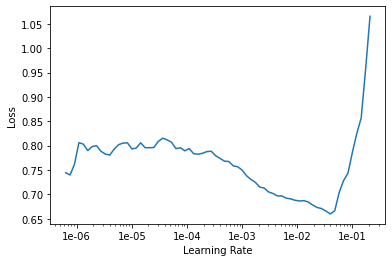

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(8, max_lr = slice(2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.713875,0.362025,0.863889,00:55
1,0.596105,0.343166,0.847222,00:50
2,0.537351,0.331757,0.861111,00:50
3,0.497363,0.317239,0.872222,00:50
4,0.465858,0.283662,0.883333,00:49
5,0.429088,0.288920,0.877778,00:50
6,0.418217,0.290052,0.877778,00:50
7,0.407651,0.287319,0.875000,00:50


In [25]:
learn.save('HighLow-2-1')

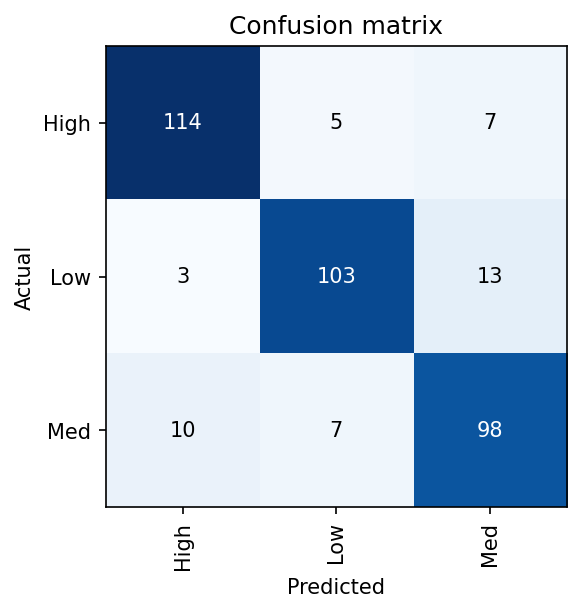

In [26]:

learn.load('HighLow-2-1');
learn = learn.to_fp32()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 150)

In [27]:
learn.load('HighLow-2-1');
learn = learn.to_fp16()
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


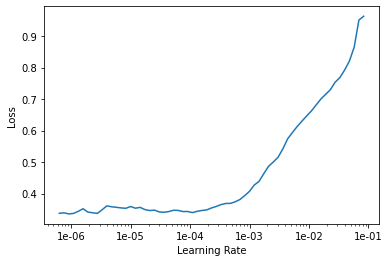

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.345418,0.289391,0.880556,01:05
1,0.366807,0.283659,0.877778,01:00
2,0.350246,0.263058,0.897222,00:59
3,0.328041,0.254237,0.894444,00:59
4,0.306596,0.255529,0.897222,01:00
5,0.301113,0.248467,0.897222,01:00
6,0.291324,0.246645,0.897222,00:59
7,0.275930,0.244391,0.897222,01:00


In [30]:
learn.save('HighLow-2-3');

In [31]:
learn.load('HighLow-2-3');
learn.data=data

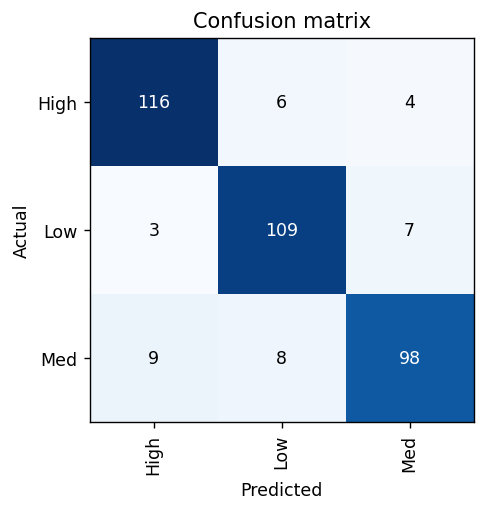

In [32]:
learn.load('HighLow-2-3');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi = 125)

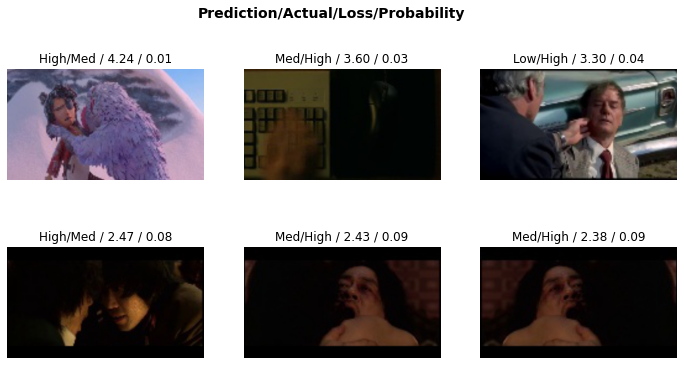

In [33]:
learn = learn.to_fp32()
interp.plot_top_losses(6, heatmap=False, figsize=(12,6))

In [34]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 113, 200]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 113, 200]       128        True      
______________________________________________________________________
ReLU                 [64, 113, 200]       0          False     
______________________________________________________________________
MaxPool2d            [64, 57, 100]        0          False     
______________________________________________________________________
Conv2d               [64, 57, 100]        4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 57, 100]        128        True      
______________________________________________________________________
Conv2d               [64, 57, 100]        36,864     True      
___________________________________________________

In [38]:
parent_dir = '/content/drive/MyDrive/models/'
directory = 'FINAL_FastAI_HighLow'
joined_path = os.path.join(parent_dir, directory)
os.mkdir(joined_path)

In [39]:
%cd /content/drive/MyDrive/models/FINAL_FastAI_HighLow

/content/drive/MyDrive/models/FINAL_FastAI_HighLow


In [40]:
learn.export()